In [2]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="doubleclientdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [3]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*,
	COUNT(e.message_marker)
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

2client_attempt
2client_no_attacker_attempt
2client_no_attacker_attempt_multiple_trials


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system,count
0,2client_attempt,1,4,1,originserver,pc2133,ubuntu1804-std,367227
1,2client_attempt,1,6,2,receiver,pc2133,ubuntu1804-std,156221
2,2client_attempt,1,1,3,attacker,pc2133,ubuntu1804-std,291104
3,2client_attempt,1,5,4,proxy,microcloud,ubuntu1804-std,892048
4,2client_attempt,1,2,5,client1,pc3000,ubuntu1804-std,31757
5,2client_attempt,1,3,6,client2,pc2133,ubuntu1804-std,33297
6,2client_no_attacker_attempt,1,10,1,originserver,pc2133,ubuntu1804-std,83770
7,2client_no_attacker_attempt,1,11,4,proxy,microcloud,ubuntu1804-std,167540
8,2client_no_attacker_attempt,1,8,5,client1,pc3000,ubuntu1804-std,40371
9,2client_no_attacker_attempt,1,9,6,client2,pc2133,ubuntu1804-std,42549


In [4]:
exp_id = "2client_attempt"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    
pprint(node_map_node_id)
pprint(node_map_dnid)

{'attacker': 3,
 'client1': 5,
 'client2': 6,
 'originserver': 1,
 'proxy': 4,
 'receiver': 2}
{'attacker': 1,
 'client1': 2,
 'client2': 3,
 'originserver': 4,
 'proxy': 5,
 'receiver': 6}


In [5]:
client_messages_sql = f"""
SELECT
    e.observe_timestamp,
    e.message_marker,
    e.trial,
	m.src_id,
	m.dst_id
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
WHERE
	e.observer_id IN ({','.join(map(str, [node_map_dnid['client1'], node_map_dnid['client2']]))})
ORDER BY
    e.observe_timestamp
;
"""

df = pd.read_sql_query(client_messages_sql, con)
con.commit()

# Negate timestamp of client src message to measure RTT
df["observe_timestamp"] = df.where(df["src_id"] == node_map_node_id['client1'], df["observe_timestamp"] * -1, axis=0)
df["observe_timestamp"] = df.where(df["src_id"] == node_map_node_id['client2'], df["observe_timestamp"] * -1, axis=0)

rtts_df = df.groupby(by=["trial", "message_marker"]).agg(\
                                              rtt_sec=("observe_timestamp", "sum"), 
                                              timestamp=("observe_timestamp", "max"),
                                              src_id=("src_id", "median")).reset_index()
rtts_df = rtts_df[rtts_df["rtt_sec"] > 0]
rtts_df["rtt_ms"] = rtts_df["rtt_sec"] * 1e3

for t in rtts_df["trial"].unique():
    print(f"Trial {t}")
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        print(f"-- Client {client_number}")
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        client_trial_df["count"] = np.arange(1, len(client_trial_df) + 1)
        print(client_trial_df.describe())
        average_rps = client_trial_df["count"].max() / (client_trial_df["timestamp"].max() - client_trial_df["timestamp"].min())
        print(f"\naverage_rps={average_rps}")
        print()

rtts_df

Trial 1
-- Client 1
         trial  message_marker       rtt_sec     timestamp   src_id  \
count  15866.0    15866.000000  15866.000000  1.586600e+04  15866.0   
mean       1.0   236667.909807      0.004399  1.637010e+09      4.5   
std        0.0   131569.790974      0.001538  2.884051e+01      0.0   
min        1.0        1.000000      0.003640  1.637010e+09      4.5   
25%        1.0   299475.250000      0.004203  1.637010e+09      4.5   
50%        1.0   307297.000000      0.004353  1.637010e+09      4.5   
75%        1.0   315317.500000      0.004441  1.637010e+09      4.5   
max        1.0   323349.000000      0.153270  1.637010e+09      4.5   

             rtt_ms         count  
count  15866.000000  15866.000000  
mean       4.398719   7933.500000  
std        1.537922   4580.264021  
min        3.640175      1.000000  
25%        4.202843   3967.250000  
50%        4.352808   7933.500000  
75%        4.441023  11899.750000  
max      153.270006  15866.000000  

average_rps=162

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,trial,message_marker,rtt_sec,timestamp,src_id,rtt_ms
0,1,1,0.091914,1.637010e+09,4.5,91.913939
1,1,2,0.007422,1.637010e+09,4.5,7.421970
2,1,3,0.006724,1.637010e+09,4.5,6.724119
3,1,4,0.006642,1.637010e+09,4.5,6.642103
4,1,5,0.007199,1.637010e+09,4.5,7.199049
...,...,...,...,...,...,...
32514,1,323619,0.004338,1.637010e+09,5.0,4.338026
32515,1,323620,0.004341,1.637010e+09,5.0,4.340887
32516,1,323621,0.004451,1.637010e+09,5.0,4.451036
32517,1,323622,0.004500,1.637010e+09,5.0,4.500151


<IPython.core.display.Javascript object>


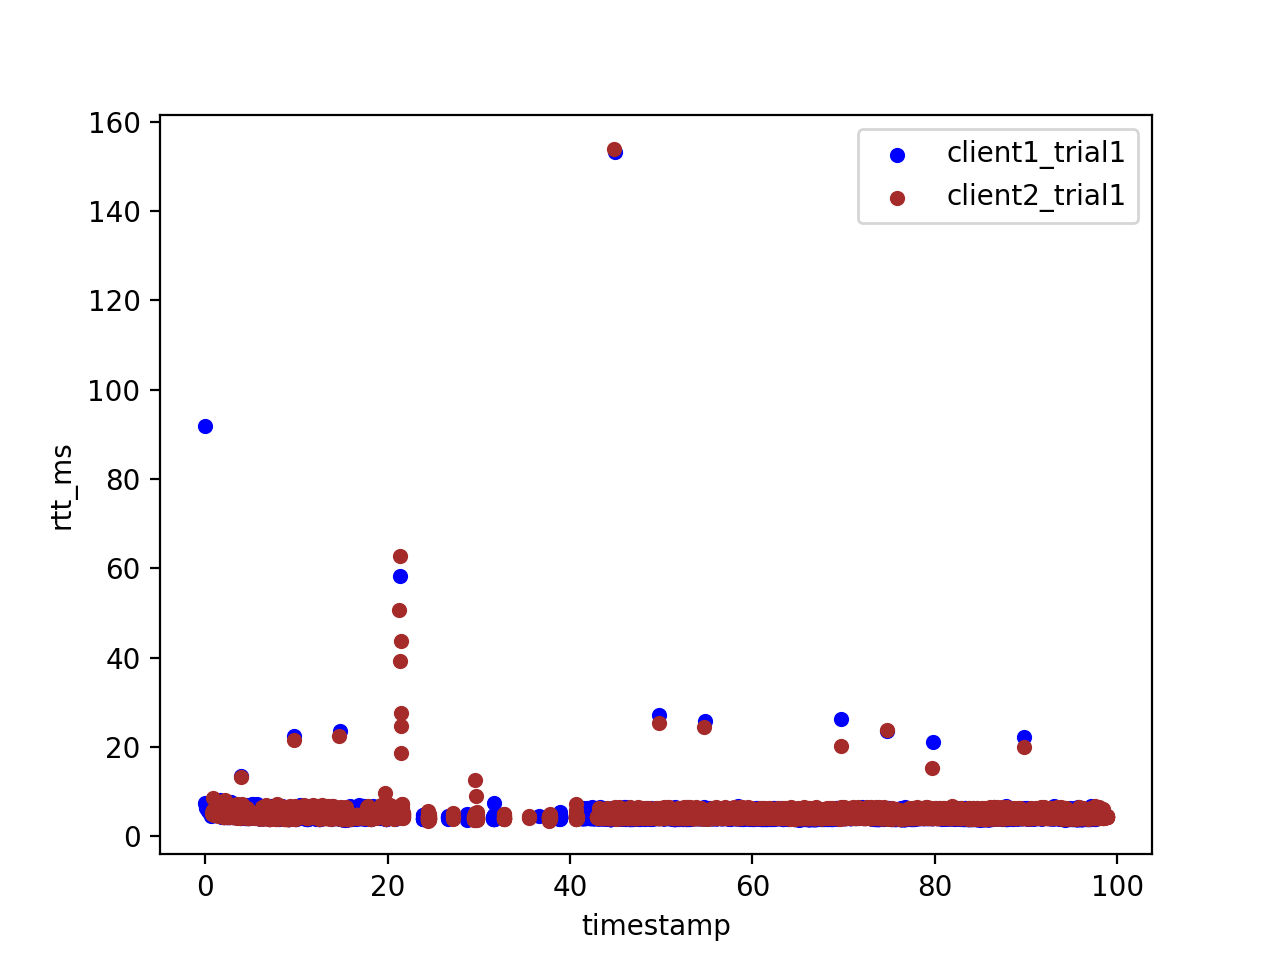

In [6]:
%matplotlib notebook

ax = None
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon"}
for t in rtts_df["trial"].unique():
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    for client_number, src_id in enumerate(trial_df["src_id"].unique(), start=1):
        client_trial_df = trial_df[trial_df["src_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        if ax:
            client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, ax=ax, color=color_map[(client_number, t)])
        else:
            ax = client_trial_df.plot(kind="scatter", x="timestamp", y="rtt_ms", label=label, color=color_map[(client_number, t)])
plt.show()